# Fast Agent - Build a SQL Agent fast!

<img src="./assets/LC_L1_top.png" align="left" width="500">

## Setup

Load and/or check for needed environmental variables

In [11]:
import os 
from dotenv import load_dotenv
from env_utils import doublecheck_env, doublecheck_pkgs

# Load environment variables from .env
load_dotenv()

# Check and print results
doublecheck_env("example.env")  # check environmental variables
doublecheck_pkgs(pyproject_path="pyproject.toml", verbose=True)   # check packages

OPENAI_API_KEY=<not set>
LANGSMITH_API_KEY=****here
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****ials
Python 3.11.6 satisfies requires-python: >=3.11
package                | required | installed | status | path                                                                            
---------------------- | -------- | --------- | ------ | --------------------------------------------------------------------------------
jupyter                | >=1.0.0  | 1.1.1     | ✅ OK   | …g-oss-models/quickstart-langchain-essentials/.venv/lib/python3.11/site-packages
langchain              | >=1.0.0  | 1.0.8     | ✅ OK   | …g-oss-models/quickstart-langchain-essentials/.venv/lib/python3.11/site-packages
langchain-anthropic    | >=1.0.0  | 1.1.0     | ✅ OK   | …g-oss-models/quickstart-langchain-essentials/.venv/lib/python3.11/site-packages
langchain-community    | >=0.4.0  | 0.4.1     | ✅ OK   | …g-oss-models/quickstart-langchain-essentials/.venv/lib/python3.11/site-packages
langchain-mcp-adapters

In [12]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

Define the runtime context to provide the agent and tools with access to the database.

In [13]:
from dataclasses import dataclass

from langchain_community.utilities import SQLDatabase


# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: SQLDatabase

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

In [14]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

Add a system prompt to define your agents behavior.

In [15]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create your agent! Add a model, tools, a prompt, and the runtime access, and go!  You can choose many agents from our [integrations](https://docs.langchain.com/oss/python/integrations/providers) list. 

In [20]:
from langchain_ollama import ChatOllama

model = ChatOllama(model=os.getenv("OLLAMA_MODEL") , temperature= 0 , base_url=os.getenv("OLLAMA_BASE_URL"))

In [19]:
from langchain.agents import create_agent

agent = create_agent(
    model=model,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

Here's a display of the agent ReAct Loop.

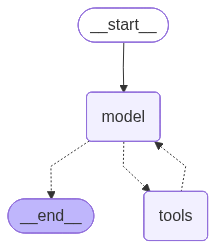

In [21]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [22]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

/Users/george/Documents/github/langchain-academy-using-oss-models/quickstart-langchain-essentials/.venv/lib/python3.11/site-packages/pydantic/v1/main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


================================ Human Message =================================

Which table has the largest number of entries?


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


KeyboardInterrupt: 

In [9]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_HYISrfBIIfMxf2aJBPTkEXcP)
 Call ID: call_HYISrfBIIfMxf2aJBPTkEXcP
  Args:
    query: SELECT g.Name AS genre_name, AVG(t.Milliseconds)/1000.0 AS avg_seconds, AVG(t.Milliseconds) AS avg_milliseconds
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY avg_milliseconds DESC
LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: genres
[SQL: SELECT g.Name AS genre_name, AVG(t.Milliseconds)/1000.0 AS avg_seconds, AVG(t.Milliseconds) AS avg_milliseconds
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY avg_milliseconds DESC
LIMIT 1;]
(Background on this error at: https://sqlalche

In [10]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_l1UWwgSfPDbtNMgiOqdd1QHf)
 Call ID: call_l1UWwgSfPDbtNMgiOqdd1QHf
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_XVZ2quL9z2LYrw1gb6jknw5L)
 Call ID: call_XVZ2quL9z2LYrw1gb6jknw5L
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('

**Create your own query here!**  Add some questions of your own.

In [ ]:
question = "TRY YOUR OWN QUERY HERE"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

### Let's try this Studio